# Car Price Prediction

In [1247]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from bs4 import BeautifulSoup as bs
import requests
import re
import time
from datetime import date
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
import pickle
%matplotlib inline

## Getting scraped data from csv file

In [1248]:
df = pd.read_csv('data/car_info.csv', index_col=0)

In [1249]:
df = df.dropna()

## Data cleaning

### Fuel type

In [1250]:
def is_gas(row):
    regex1 = re.compile('.*Gas.*')
    regex2 = re.compile('.*Flex.*')
    if regex1.match(row.fuel_type) or \
    regex2.match(row.fuel_type) or \
    row.fuel_type == 'Hybrid ':
        return 1
    else:
        return 0
    
def is_diesel(row):
    regex1 = re.compile('Diesel.*')
    regex2 = re.compile('.*Flex Fuel.*')
    if regex1.match(row.fuel_type) or \
    regex2.match(row.fuel_type):
        return 1
    else:
        return 0
    
def is_electric(row):
    regex = re.compile('.*Electric.*')
    if regex.match(row.fuel_type) or \
    row.fuel_type == 'Hybrid ':
        return 1
    else:
        return 0

In [1251]:
df['is_gas'] = df.apply(lambda row : is_gas(row), axis=1)
df['is_diesel'] = df.apply(lambda row : is_diesel(row), axis=1)
df['is_electric'] = df.apply(lambda row : is_electric(row), axis=1)

### Year

In [1252]:
def get_year_make_model(row):
    i = row['name']
    w = i.split()
    return w

In [1253]:
df['age'] = df.apply(lambda row : date.today().year - int(get_year_make_model(row)[0]), axis=1)\
    .astype('int')
df['make_model'] = df.apply(lambda row : get_year_make_model(row)[1] + get_year_make_model(row)[2], axis=1)
# df['model'] = df.apply(lambda row : get_year_make_model(row)[2], axis=1)

### MPG

In [1254]:
# drop rows with blank mpg
df = df[df['mpg'] != '–']
df = df[df['mpg'] != 'None']

In [1255]:
def get_low_mpg(row):
    i = row.mpg.find('–')
    if i != -1:
        return row.mpg[0:i]
    else:
        return row.mpg

def get_high_mpg(row):
    i = row.mpg.find('–')
    if i != -1:
        return row.mpg[i+1:]
    else:
        return 0

In [1256]:
df['mpg'] = df.apply(lambda row : int(get_low_mpg(row)) + int(get_high_mpg(row)), axis=1).astype('int')

### Transmission

In [1257]:
def is_auto(row):
    regex = re.compile('.*([A|a]uto|A/T|Dual Shift).*')
    if regex.match(row.transmission):
        return 1
    else:
        return 0

def is_cvt(row):
    regex = re.compile('.*(CVT|Variable).*')
    if regex.match(row.transmission):
        return 1
    else:
        return 0
    
def is_manual(row):
    regex = re.compile('.*(Manual|M/T).*')
    if regex.match(row.transmission):
        return 1
    else:
        return 0
    
def get_speed(row):
    tmp = row.transmission
    tmp = re.sub('[^0-9]', '', tmp)
    if tmp == '':
        return 0
    else:
        return int(tmp)

In [1258]:
df['is_auto'] = df.apply(lambda row : is_auto(row), axis=1)
df['is_cvt'] = df.apply(lambda row : is_cvt(row), axis=1)
df['is_manual'] = df.apply(lambda row : is_manual(row), axis=1)
df['speed'] = df.apply(lambda row : get_speed(row), axis=1)

### Engine

In [1259]:
def get_L(row):
    i = row.engine.find('L')
    if i == -1:
        return 0
    else:
        return float(row.engine[i-3:i])

def get_V(row):
    i = row.engine
    a = re.compile('.*16V.*')
    b = re.compile('.*24V.*')
    c = re.compile('.*32V.*')
    d = re.compile('.*48V.*')
    e = re.compile('.*12V.*')
    if a.match(i):
        return 16
    elif b.match(i):
        return 24
    elif c.match(i):
        return 32
    elif d.match(i):
        return 48
    elif e.match(i):
        return 12
    else:
        return 0

In [1260]:
df['engine_L'] = df.apply(lambda row : get_L(row), axis=1).astype('float')
df['engine_V'] = df.apply(lambda row : get_V(row), axis=1).astype('float')

### Drivetrain

In [1261]:
# drop rows with blank drivetrain
df.drivetrain = df.drivetrain.apply(lambda x : x[1:-1])
df = df[df['drivetrain'] != '–']

In [1262]:
def get_drivetrain(row):
    i = row.drivetrain
    four = re.compile('.*(Front|Rear|FWD).*')
    two = re.compile('.*(All|Four|4WD|AWD).*')
    if four.match(i):
        return 4
    elif two.match(i):
        return 2
    else:
        return 0

In [1263]:
df['drivetrain'] = df.apply(lambda row : get_drivetrain(row), axis=1)

## Car make and model

In [1264]:
df = pd.get_dummies(df, columns=['make_model'], \
                    prefix='mm', prefix_sep='_')
df = pd.get_dummies(df, columns=['drivetrain'], \
                    prefix='dt', prefix_sep='_')

### Drop useless columns

In [1265]:
df = df.drop(columns=\
             ['index', 'name', 'ex_color', 'in_color', \
              'mpg', 'fuel_type', 'transmission', 'engine'])

In [1266]:
df

,price,mileage,is_gas,is_diesel,is_electric,age,is_auto,is_cvt,is_manual,speed,...,mm_VolkswagenTaos,mm_VolkswagenTiguan,mm_VolvoS60,mm_VolvoS90,mm_VolvoV60,mm_VolvoV90,mm_VolvoXC60,mm_VolvoXC90,dt_2,dt_4
0,27995.0,29192,1,0,0,3,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,52458.0,56059,0,0,1,3,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,22115.0,15039,1,0,0,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,19500.0,61754,1,0,0,5,1,0,0,6,...,0,0,0,0,0,0,0,0,1,0
4,34952.0,26577,1,0,0,2,1,0,0,8,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,44998.0,17090,1,0,0,3,1,0,0,8,...,0,0,0,0,0,0,0,0,1,0
1191,18980.0,48959,1,0,0,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1192,17629.0,66881,1,0,0,3,1,0,0,6,...,0,0,0,0,0,0,0,0,0,1
1193,82900.0,47936,0,0,1,5,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## Building regression model

## Virtualization

In [1267]:
# plt.figure(dpi=100)
# sns.pairplot(df)

### Divide dataset

In [1268]:
train_df, test_df = train_test_split(df, test_size=0.2)

### Fit model

In [1269]:
X = train_df.drop(columns=['price'], axis=1)
y = train_df.price

model = LinearRegression()
model.fit(X, y)
model.score(X, y)

0.9404755933581701

In [1270]:
# test
X_test = test_df.drop(columns=['price'], axis=1)
y_test = test_df.price
model.score(X_test, y_test)

0.7973783402038714

In [1271]:
test_df

,price,mileage,is_gas,is_diesel,is_electric,age,is_auto,is_cvt,is_manual,speed,...,mm_VolkswagenTaos,mm_VolkswagenTiguan,mm_VolvoS60,mm_VolvoS90,mm_VolvoV60,mm_VolvoV90,mm_VolvoXC60,mm_VolvoXC90,dt_2,dt_4
220,29995.0,45925,1,0,0,7,1,0,0,5,...,0,0,0,0,0,0,0,0,1,0
1100,24900.0,12974,1,0,0,2,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
747,35000.0,35849,1,0,0,3,1,0,0,8,...,0,0,0,0,0,0,0,0,0,1
363,34999.0,20868,1,0,0,3,1,0,0,8,...,0,0,0,0,0,0,1,0,1,0
1178,32950.0,114808,1,0,0,6,1,0,0,8,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,30883.0,44067,1,0,0,2,1,0,0,10,...,0,0,0,0,0,0,0,0,0,1
187,70950.0,29825,1,0,0,4,1,0,0,8,...,0,0,0,0,0,0,0,0,1,0
337,41990.0,11309,1,0,0,1,1,0,0,6,...,0,0,0,0,0,0,0,0,1,0
562,38000.0,39886,1,0,0,4,1,0,0,8,...,0,0,0,0,0,0,0,0,1,0


Text(0, 0.5, 'Price')

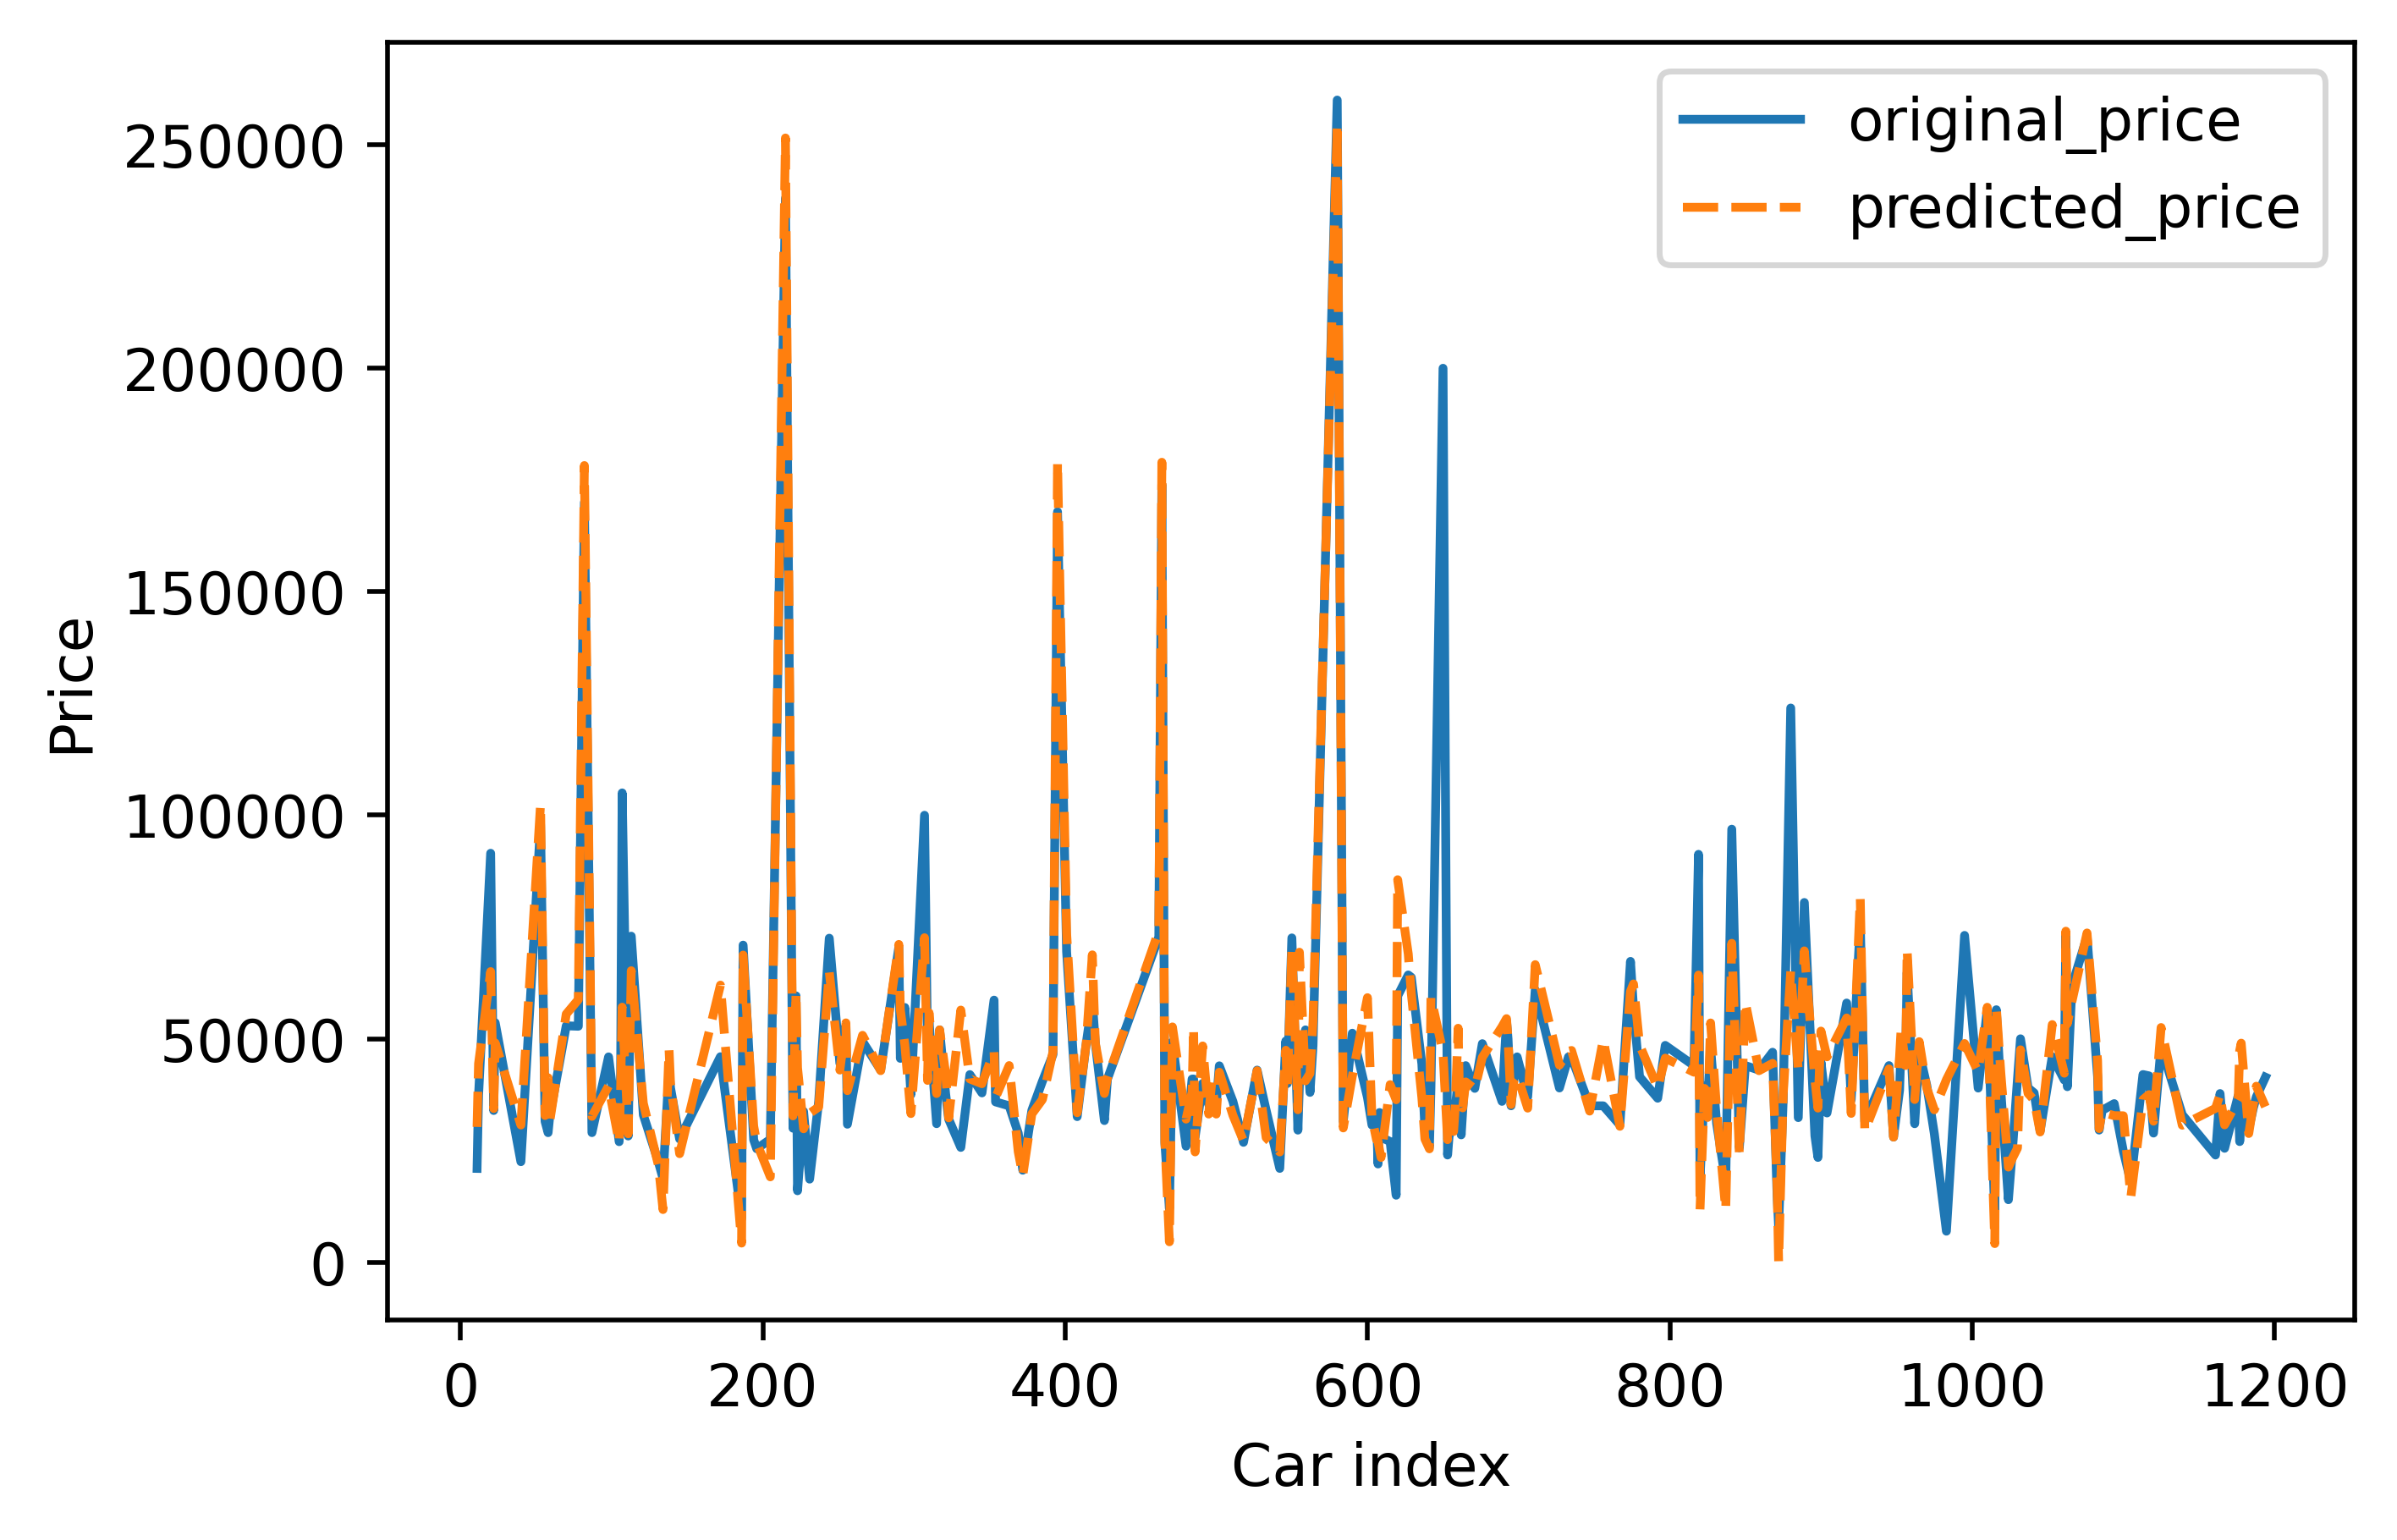

In [1272]:
# model.predict(X_test)
plt.figure(dpi=500)
df_res = pd.DataFrame()
df_res['original_price'] = y_test
df_res['predicted_price'] = model.predict(X_test)
ax = sns.lineplot(data=df_res)
plt.xlabel('Car index')
plt.ylabel('Price')
# plt.savefig('linear_regression_test.png')

In [1273]:
# save the model
# with open('models/linear_model_pkl', 'wb') as file:
#     pickle.dump(model, file)

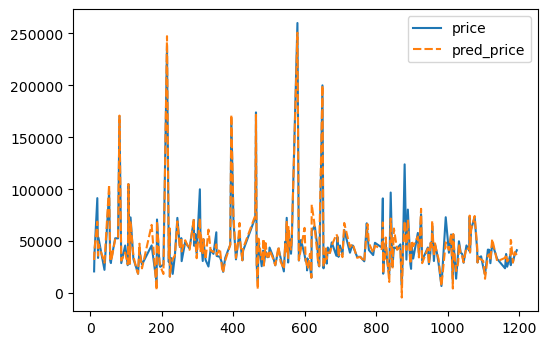

In [1274]:
# load the model from pickle file
with open('models/linear_model_pkl', 'rb') as f:
    lr = pickle.load(f)

plt.figure(dpi=100)
df_res2 = pd.DataFrame()
df_res2['price'] = y_test
df_res2['pred_price'] = lr.predict(X_test)
ax2 = sns.lineplot(data=df_res2)

In [1275]:
df

,price,mileage,is_gas,is_diesel,is_electric,age,is_auto,is_cvt,is_manual,speed,...,mm_VolkswagenTaos,mm_VolkswagenTiguan,mm_VolvoS60,mm_VolvoS90,mm_VolvoV60,mm_VolvoV90,mm_VolvoXC60,mm_VolvoXC90,dt_2,dt_4
0,27995.0,29192,1,0,0,3,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,52458.0,56059,0,0,1,3,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,22115.0,15039,1,0,0,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,19500.0,61754,1,0,0,5,1,0,0,6,...,0,0,0,0,0,0,0,0,1,0
4,34952.0,26577,1,0,0,2,1,0,0,8,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,44998.0,17090,1,0,0,3,1,0,0,8,...,0,0,0,0,0,0,0,0,1,0
1191,18980.0,48959,1,0,0,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1192,17629.0,66881,1,0,0,3,1,0,0,6,...,0,0,0,0,0,0,0,0,0,1
1193,82900.0,47936,0,0,1,5,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [1276]:
# sns.pairplot(df[['price', 'mileage', 'age', 'speed']])

In [1277]:
train_df, test_df = train_test_split(df, test_size=0.2)
X = train_df.drop(columns=['price'], axis=1)
y = train_df.price

In [1278]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

alphas = 10**np.linspace(-4, 4, 100)

lasso = LassoCV(alphas=alphas, cv=5)
lasso.fit(X_scaled, y)
lasso.score(X_scaled, y)

/Users/darren/opt/anaconda3/envs/regression/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76622215.01107025, tolerance: 63169373.07830259
  model = cd_fast.enet_coordinate_descent_gram(
/Users/darren/opt/anaconda3/envs/regression/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2171131524.222809, tolerance: 63169373.07830259
  model = cd_fast.enet_coordinate_descent_gram(
/Users/darren/opt/anaconda3/envs/regression/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4737392391.505489, tolerance: 63169373.07830259
  model = cd_fast.enet_coordinate_descent_gram(
/Users/

/Users/darren/opt/anaconda3/envs/regression/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16016279230.149683, tolerance: 63169373.07830259
  model = cd_fast.enet_coordinate_descent_gram(
/Users/darren/opt/anaconda3/envs/regression/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16032850128.68134, tolerance: 63169373.07830259
  model = cd_fast.enet_coordinate_descent_gram(
/Users/darren/opt/anaconda3/envs/regression/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16046679910.201946, tolerance: 63169373.07830259
  model = cd_fast.enet_coordinate_descent_gram(
/User

0.9345807348332567

In [1280]:
X_test_scaled = scaler.transform(X_test)

lasso.score(X_test_scaled, y_test)

0.933958456220377

In [1281]:
# save the model
# with open('models/lasso_model_pkl', 'wb') as file:
#     pickle.dump(lasso, file)

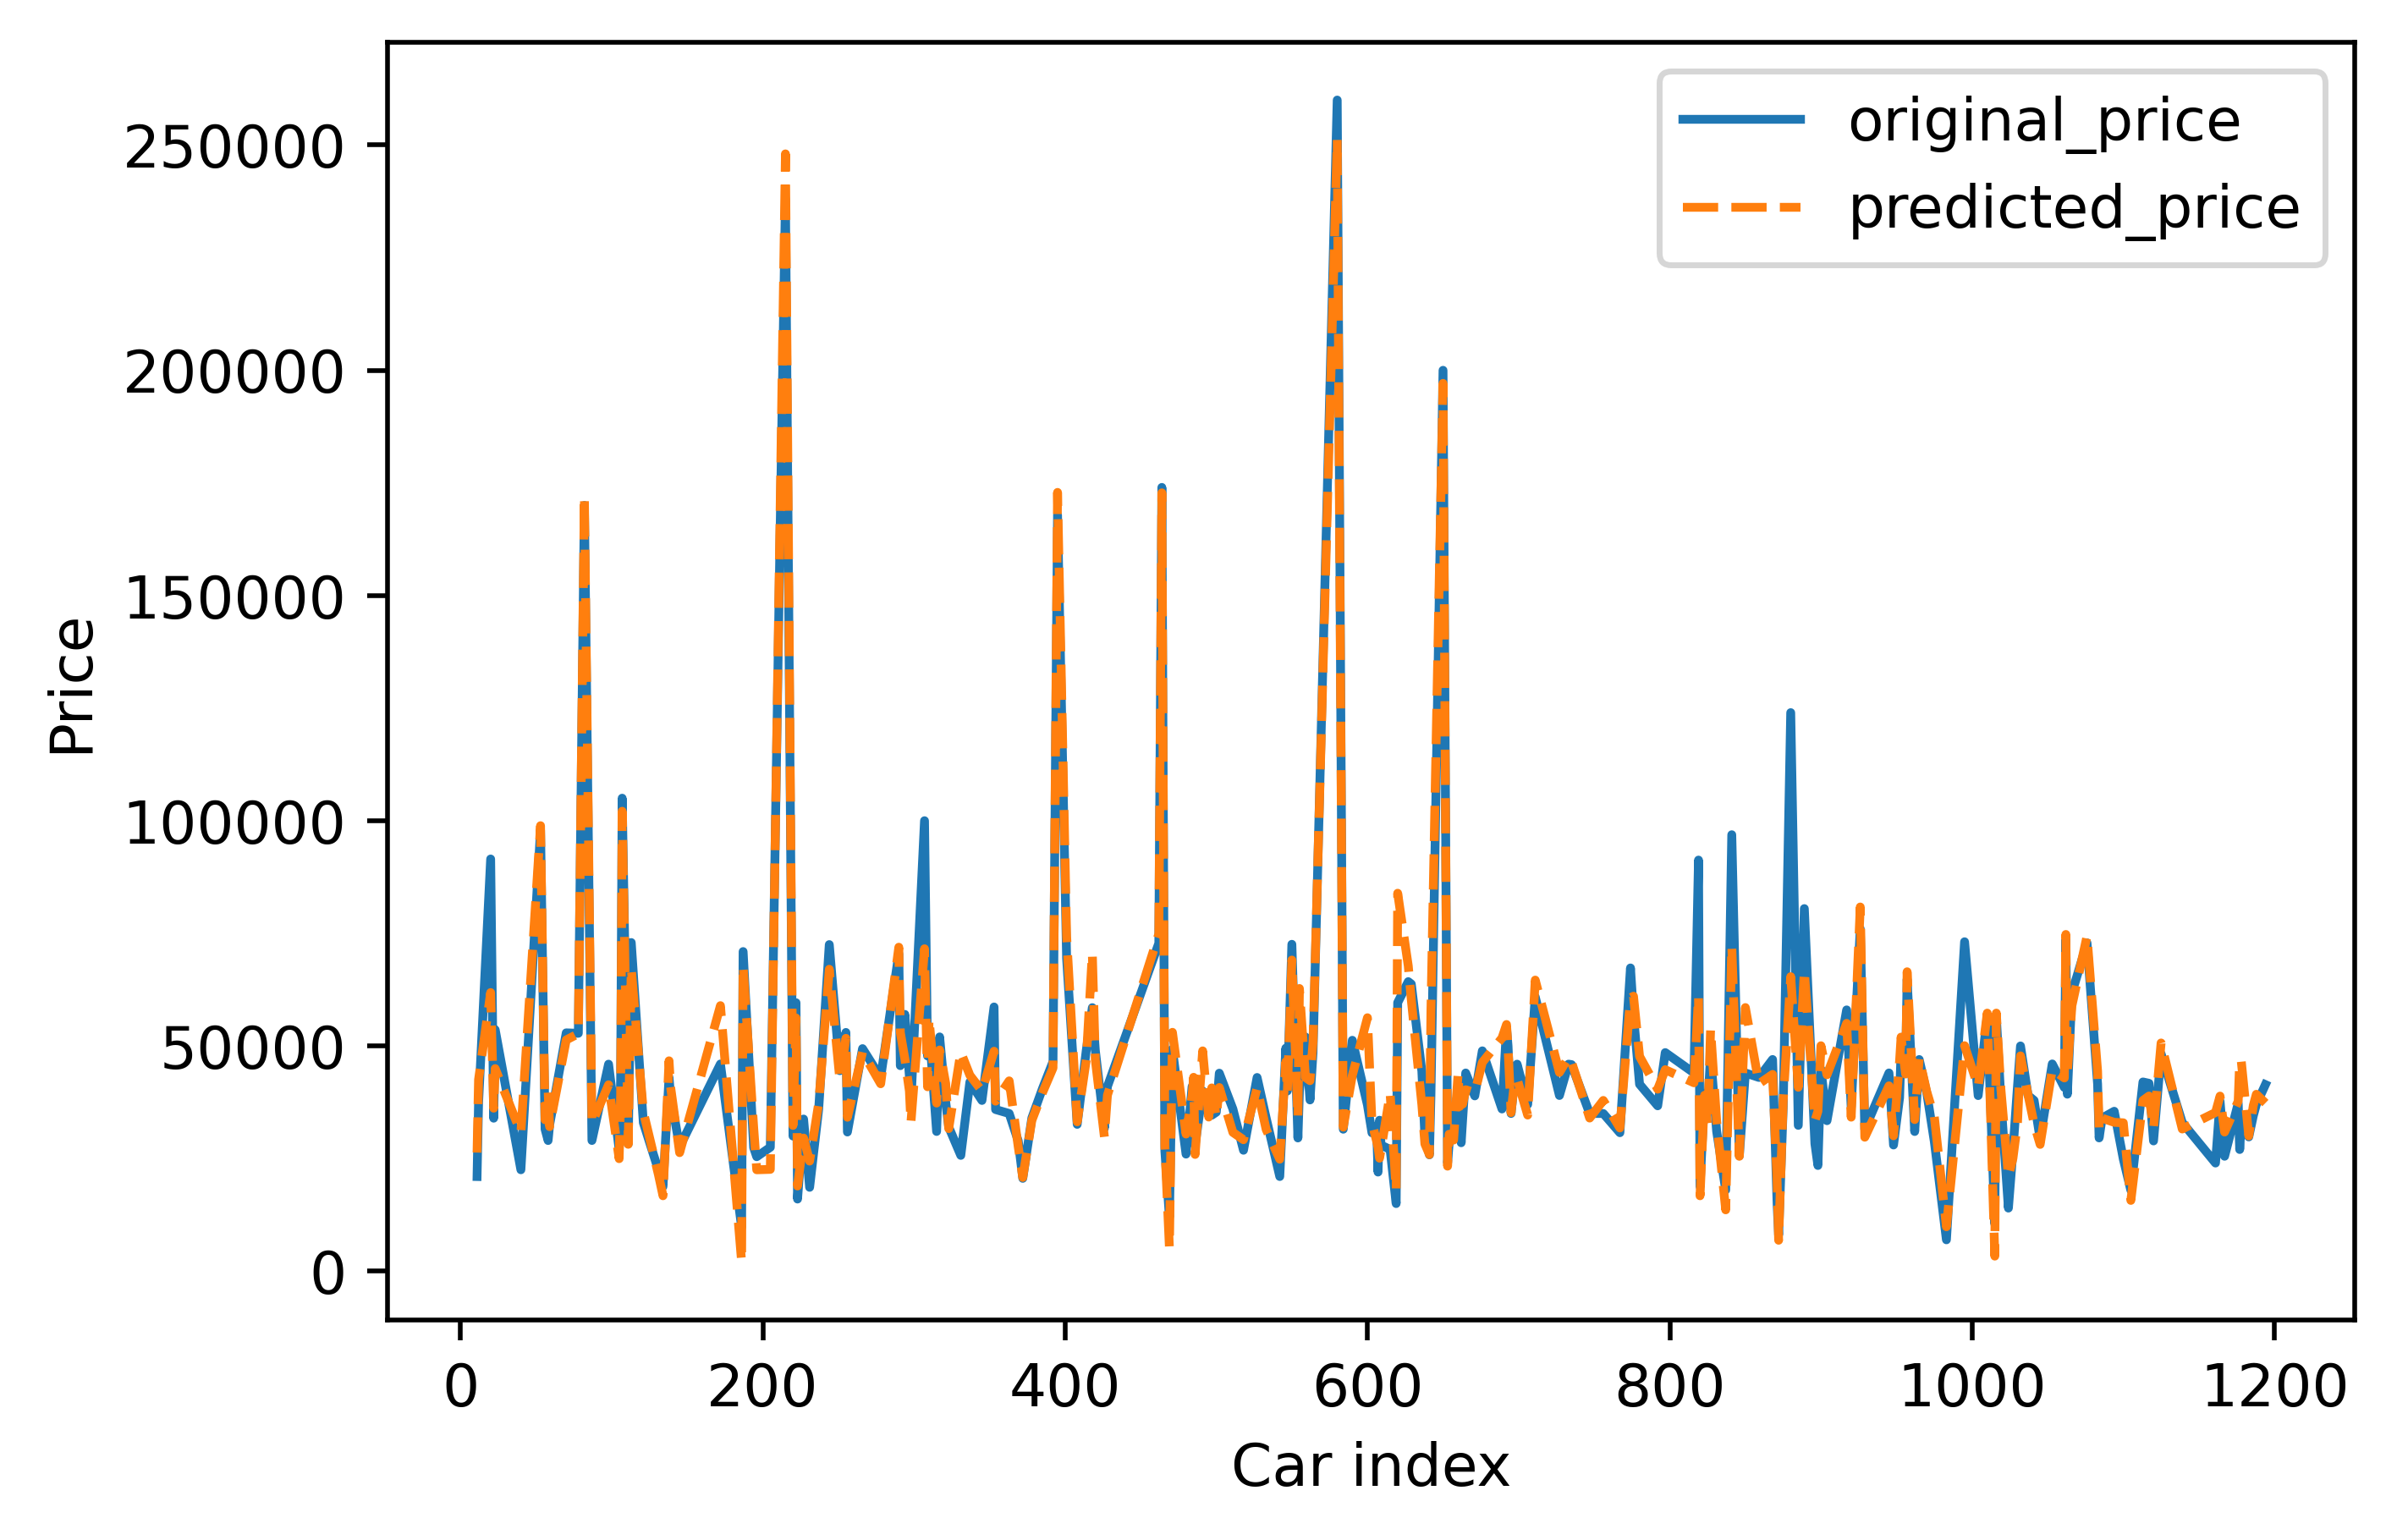

In [1285]:
# load the model from pickle file
with open('models/lasso_model_pkl', 'rb') as f:
    lr = pickle.load(f)

# model.predict(X_test)
plt.figure(dpi=500)
lasso_res = pd.DataFrame()
lasso_res['original_price'] = y_test
lasso_res['predicted_price'] = lr.predict(X_test_scaled)
ax = sns.lineplot(data=lasso_res)
plt.xlabel('Car index')
plt.ylabel('Price')
plt.savefig('lasso_regression_test.png')

In [1283]:
lr.score(X_test_scaled, y_test)

0.933958456220377